### Import dataset

In [ ]:
# !pip install datasets

In [1]:
!pip install -U datasets

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Tokenizing the dataset

Types
- Character level: Major issue is Ballooning effect. The number of tokens shoots up and this may overwhelm the LLM context window. Also it destroys the meaning of the underlying text

- Word level: Leads to Out-of-vocabulary errors. The number of words we need to keep in vocabulary is also huge

- Subword tokenization: We start by adding characters in vocabulary. We merge characters which occur together frequently in the dataset. This means we need not have every word in language as a separate token in the vocabulary

In [3]:
!pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

# Map each story to its tokens and length of tokens
def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 which fits in 2 bytes)

        # We are saving the tokenized result on disk using memmap
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

### Creating input output pairs

* One thing we need to know for this is the context size of the model, as well as the batch size so that we know how regularly we shall update the gradients

* Lets say context size is 3

Input = [i, am, chinmay]
output = [am, chinmay, kuchinad]

In this case we have 3 prediction tasks. The model is creating labels on its own. This is a self-supervised autoregressive training example.



In [5]:
import torch

In [6]:
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak. By doing this we release the cached pages when we go out of scope
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,)) # Block size is context window
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]) # Inputs shifted to the right by 1

    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True) (prevents OS from switching memory pages being used by GPU)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Assembling the architecture

#### 1. Token Embeddings

Token IDs -> embedding vectors

#### 2. RMS Norm
- No mean calculation needed unlike in layer norm
- Divide each vector by RMS (square root of variance + epsilon). Also have trainable scale and shift params

#### 3. Sliding window attention
- Multi-query attention: We save computation by sharing same keys and values across all heads. Reduces size of KV cache and number of trainable params

- Sliding attention: Every token cannot peak into future(causal) and also not too far back into the past(sliding window size has to be defined)

Compute requirements -> O(n^2) -> O(n*W), W -> Window size

- Gemma has 3 full attention and 15 sliding attention (total transformer blocks)

#### 4. Rotary Positional Encodings
- Sine based absolute positional encodings contaminated the word meanings
- In RoPE we take query and key vectors and apply sine and cosine based rotations to these (these are rotations and don't affect the magnitude)
- Closer queries have similar positional encodings, which increases with distance(index)

#### 5. QK Norm
- RMS norm applied to query and key vectors before calculating attention scores

#### 6. Feedforward neural network
- FFN is usually expansion-contraction network. Expansion (lower dim -> higher dim) and contraction is the opposite. In gemma we have two separate expansion network which is then subjected to element-wise multiplication before sending to the contraction block.
- Amongst the expansion blocks, one has a GeLU activation while the other doesnt

Effectively its this:
FFN(x)=W2​⋅((W1​⋅x)⊙Activation(Wgate​⋅x))

Empirically found to improve gradient flow

## Workflow with dimensions

- Gemma Embedding size - `D`
- Let us have N input tokens so after embedding phase dimension is `[N, D]`
- After RMSNorm shape stays intact `[N, D]`
- Let `Dout` be the output dimension (number of heads * head_dimension)
- After attention computation, the shape we now have is `[N, Dout]` which after output projection is brough back to `[N, D]`
- The residual connections and the RMSNorms dont affect the dimensions
- In the FFN, expansion and contraction takes place to ultimately return `[N, D]`
- This is for one transformer block, we obtain such outputs from the 18 transformer blocks present. We send this to the output layer where we go from embedding dimension layer -> vocabulary size

`[N, D] -> [N, V]`

- We sample the output and for each token position we check which vocabulary word has the highest probability, and use that to calculate the loss (cross entropy loss)






### RoPE

In [7]:
def compute_rope_params(head_dim, theta_base = 10_000,ctx_len = 4096, dtype = torch.float32):
    assert head_dim % 2 == 0

    # Inverse frequencies for D/2 pairs
    i = torch.arange(0, head_dim//2, dtype= dtype)
    inv_freq = 1.0 / (theta_base **(i / (head_dim))) # Shape : (D/2, )
    pos = torch.arange(ctx_len, dtype= dtype) # Shape : (T, )

    angles = pos[:, None] * inv_freq[None, :] # Shape : [T, D/ 2]
    angles = torch.cat([angles, angles], dim = 1) # (T, D) duplication for the two halves
    return torch.cos(angles), torch.sin(angles) # (T, D) , (T, D)

In [8]:
def apply_rope(x, cos, sin):
    """
    x : (B, H, T, D)
    cos : (T, D)
    sin : (T, D)
    out : (B, H, T, D)
    """
    B, H, T, D = x.shape
    assert D % 2 == 0

    # Splitting last dimension into two halves
    x1 = x[..., :D//2]
    x2 = x[..., D//2:]

    # Building the rotated vector (-x2, x1)
    rot = torch.cat([-x2, x1], dim =-1) # Concatenating (B, H, T, D/2) and (B,H, T, D/ 2) to get (B, H, T, D)

    c = cos[:T, :].unsqueeze(0).unsqueeze(0) # (1, 1, T, D)
    s = sin[:T, :].unsqueeze(0).unsqueeze(0) # (1, 1, T, D)

    # elementwise rotation:
    # For each pair (x_even, x_odd):
    # x_even' =  x_even * cos - x_odd * sin
    # x_odd'  =  x_even * sin + x_odd * cos
    x_rot = x*c + rot*s
    return x_rot.to(dtype=x.dtype)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

### RMSNorm

In [10]:
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False):
        super().__init__()
        self.eps = eps
        # Gemma3: zero-centered params, multiply by (1 + scale) in forward
        self.scale = nn.Parameter(torch.zeros(emb_dim))              # (emb_dim,)
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        """
        x : (..., emb_dim)
        """
        input_dtype = x.dtype
        x_f = x.float()
        var = x_f.pow(2).mean(dim=-1, keepdim = True) # (B, H, T, D) -> ( B, H, T, 1)
        x_norm = x_f * torch.rsqrt(var + self.eps) # Divide by RMS, rsqrt is reciprocal sqrt
        out = x_norm * (1.0 + self.scale.float())
        if self.shift is not None:
            out = out + self.shift.float()

        return out.to(input_dtype)

### Gated MLP

In [11]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        E, H, D = cfg["emb_dim"], cfg["hidden_dim"], cfg["dtype"]
        # Two parallel expansions from the SAME input x
        self.fc1 = nn.Linear(E, H, dtype=D, bias=False)  # -> a (goes through GeLU)
        self.fc2 = nn.Linear(E, H, dtype=D, bias=False)  # -> b (linear gate)
        self.fc3 = nn.Linear(H, E, dtype=D, bias=False)  # project back

    def forward(self, x):
        """
        x: (b, T, emb_dim)
        """
        a = nn.functional.gelu(self.fc1(x), approximate="tanh")    # (b, T, H)
        b = self.fc2(x)                                            # (b, T, H)
        # Element wise dot product and contract
        return self.fc3(a * b)                                     # (b, T, E)


### Grouped Query Attention

In [12]:
class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False,
        query_pre_attn_scalar=None, dtype=None,
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

        if query_pre_attn_scalar is not None:
            self.scaling = (query_pre_attn_scalar) ** -0.5
        else:
            self.scaling = (head_dim) ** -0.5


    def forward(self, x, mask, cos, sin):
        """
        x : (b, num_tokens, d_in)
        mask : (num_tokens, num_tokens), True = masked out (Broadcasts to (1, 1, T, T))
        cos/ sin : RoPE tables for Dh - (context_length, Dh)
        return: (b, num_tokens, d_in)
        """
        b, num_tokens, _ = x.shape

        # Apply projections
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        # Reshape to explicit head/group axes , then put heads first
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2) # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens,  head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2) # (b, num_tokens, num_kv_groups, head_dim) -> # (b, num_kv_groups, num_tokens, head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2) # (b, num_tokens, num_kv_groups, head_dim) -> # (b, num_kv_groups, num_tokens, head_dim)

        # Optional normalization (per head, last dim)
        if self.q_norm:
            queries = self.q_norm(queries) # (b, num_heads, num_tokens,  head_dim)
        if self.k_norm:
            keys = self.k_norm(keys) # (b, num_kv_groups, num_tokens, head_dim)

        # RoPE adds position via 2D rotations per pair, shape stays intact
        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        # Expand K/V groups across heads( num_kv_groups -> num_heads) so that shape matches k
        keys = keys.repeat_interleave(self.group_size, dim=1) # Repeats the 2nd dimension(num_kv_groups) group_size many times
        values = values.repeat_interleave(self.group_size, dim=1)

        # Scale queries
        queries = queries * self.scaling

        # Attention scores
        attn_scores = queries @ keys.transpose(2, 3) # (b, num_heads, num_tokens, num_tokens)

        # Masking before softmax. Mask(num_tokens, num_tokens) is broadcast to (1, 1, num_tokens, num_tokens)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores, dim=-1) # (b, num_heads, num_tokens, num_tokens)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out) # (b, num_heads, num_tokens, head_dim) -> # (b, num_tokens, num_heads * head_dim)
        return self.out_proj(context) # (b, num_heads, d_in)

### Transformer Block

In [13]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: dict, attn_type: str):
        super().__init__()
        self.attn_type = attn_type

        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],
            head_dim=cfg["head_dim"],
            qk_norm=cfg["qk_norm"],
            query_pre_attn_scalar=cfg["query_pre_attn_scalar"],
            dtype=cfg["dtype"],
        )
        self.ff = FeedForward(cfg)

        # Note: you have 4 RMSNorms; this is a “double-norm” style
        self.input_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_attention_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.pre_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.post_feedforward_layernorm = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(
        self,
        x,                     # (b, T, E)
        mask_global,           # (T, T) bool, Causal Mask
        mask_local,            # (T, T) bool, Sliding Window mask
        cos_global, sin_global,# (T, Dh), Gives position wrt entire sequence length
        cos_local,  sin_local, # (T, Dh), Gives position wrt the sliding window
    ):
        # ---- Attention block ----
        shortcut = x                                       # residual save
        x = self.input_layernorm(x)                        # (b, T, E)

        if self.attn_type == "sliding_attention":
            attn_mask = mask_local
            cos, sin = cos_local, sin_local
        else:
            attn_mask = mask_global
            cos, sin = cos_global, sin_global

        x_attn = self.att(x, attn_mask, cos, sin)                 # (b, T, E)
        x_attn = self.post_attention_layernorm(x_attn)            # (b, T, E)
        x = shortcut + x_attn                                     # residual sum

        # ---- FFN block ----
        shortcut = x                                           # residual save
        x_ffn = self.pre_feedforward_layernorm(x)                 # (b, T, E)
        x_ffn = self.ff(x_ffn)                                    # (b, T, E)
        x_ffn = self.post_feedforward_layernorm(x_ffn)            # (b, T, E)
        x = shortcut + x_ffn                                      # residual sum
        return x

### Gemma-3 Model

In [14]:
class Gemma3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        assert cfg["layer_types"] is not None and len(cfg["layer_types"]) == cfg["n_layers"]

        # (1) Token embedding
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        # (2) Blocks with mixed attn types (Gemma3-270M has 15 sliding window attention + 3 normal attention)
        self.blocks = nn.ModuleList([
            TransformerBlock(cfg, attn_type) for attn_type in cfg["layer_types"]
        ])

        # (3) Final norm + LM head
        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])
        self.cfg = cfg

        # (4) Precompute RoPE tables (fp32) for local and global
        # Bigger rope base(for global) -> smaller rotation angle omega, supports longer ranges
        # Smaller rope base(for local) -> faster rotation, finer local resolution
        cos_local, sin_local = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_local_base"],
            ctx_len=cfg["context_length"],
            dtype=torch.float32,
        )
        cos_global, sin_global = compute_rope_params(
            head_dim=cfg["head_dim"],
            theta_base=cfg["rope_base"],
            ctx_len=cfg["context_length"],
            dtype=torch.float32,
        )
        # store as non-persistent buffers (won’t save to state_dict)
        # Register buffer - Register a tensor with the module that isn't a parameter
        # Pytorch has trained params and non-trained buffers. We are adding these to buffers
        # persistent = False buffer isnt included in state_dict()
        self.register_buffer("cos_local",  cos_local,  persistent=False)
        self.register_buffer("sin_local",  sin_local,  persistent=False)
        self.register_buffer("cos_global", cos_global, persistent=False)
        self.register_buffer("sin_global", sin_global, persistent=False)

    def _create_masks(self, seq_len, device):
        ones = torch.ones((seq_len, seq_len), dtype=torch.bool, device=device)  # (T, T)
        mask_global = torch.triu(ones, diagonal=1)                              # Causal Mask
        far_past = torch.triu(ones, diagonal=self.cfg["sliding_window"]).T     # too-far-left
        mask_local = mask_global | far_past                                     # Sliding window mask
        return mask_global, mask_local

    def forward(self, input_ids, targets=None):
        """
        input_ids: (b, T)  int64
        targets  : (b, T)  int64 (optional)
        """
        b, seq_len = input_ids.shape
        E = self.cfg["emb_dim"]

        # Scale embeddings by sqrt(E) (common trick; stabilizes early training)
        x = self.tok_emb(input_ids) * (E ** 0.5)                   # (b, T, E)

        # Masks depend on current T
        mask_global, mask_local = self._create_masks(seq_len, x.device)  # (T,T) each

        # Pipeline through transformer blocks
        for block in self.blocks:
            x = block(
                x,
                mask_global=mask_global, mask_local=mask_local,
                cos_global=self.cos_global, sin_global=self.sin_global,
                cos_local=self.cos_local,   sin_local=self.sin_local,
            )                                                       # (b, T, E)

        x = self.final_norm(x)                                      # (b, T, E)
        logits = self.out_head(x.to(self.cfg["dtype"]))             # (b, T, V)

        loss = None
        if targets is not None:
            # Flatten to (b*T, V) vs (b*T,)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            ctx_len = self.cfg["context_length"]
            # Truncate to maximum context size of the transformer
            idx_cond = idx if idx.size(1) <= ctx_len else idx[:, -ctx_len:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float("-inf")
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

### Configuration

In [15]:
GEMMA3_CONFIG_270M = {
    "vocab_size": 50257,              # tokenizer vocab
    "context_length": 32_768,         # max T for masks/RoPE tables
    "emb_dim": 640,                   # E
    "n_heads": 4,                     # H
    "n_layers": 18,                   # depth
    "hidden_dim": 2048,               # FFN expansion H (MLP width)
    "head_dim": 256,                  # Dh (per head)
    "qk_norm": True,                  # RMSNorm on Q/K
    "n_kv_groups": 1,                 # G (GQA groups)
    "rope_local_base": 10_000.0,      # θ base for sliding attention
    "rope_base": 1_000_000.0,         # θ base for global attention
    "sliding_window": 512,            # local band width (tokens back)
    "layer_types": [
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "sliding_attention",
        "full_attention"
    ], # per-layer: "sliding_attention" or "full_attention"
    "dtype": torch.bfloat16,          # compute dtype for module params
    "query_pre_attn_scalar": 256,     # Gemma option: scale Q by 1/sqrt(this) instead of 1/sqrt(Dh)
}

torch.manual_seed(123)
model = Gemma3Model(GEMMA3_CONFIG_270M)

In [16]:
model.blocks

ModuleList(
  (0-17): 18 x TransformerBlock(
    (att): GroupedQueryAttention(
      (W_query): Linear(in_features=640, out_features=1024, bias=False)
      (W_key): Linear(in_features=640, out_features=256, bias=False)
      (W_value): Linear(in_features=640, out_features=256, bias=False)
      (out_proj): Linear(in_features=1024, out_features=640, bias=False)
      (q_norm): RMSNorm()
      (k_norm): RMSNorm()
    )
    (ff): FeedForward(
      (fc1): Linear(in_features=640, out_features=2048, bias=False)
      (fc2): Linear(in_features=640, out_features=2048, bias=False)
      (fc3): Linear(in_features=2048, out_features=640, bias=False)
    )
    (input_layernorm): RMSNorm()
    (post_attention_layernorm): RMSNorm()
    (pre_feedforward_layernorm): RMSNorm()
    (post_feedforward_layernorm): RMSNorm()
  )
)

### Loss function

In [17]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode(): # disable autograd + versioning
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                # Turns on AMP
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

### Training Configuration

#### Hyperparameters

In [18]:
learning_rate = 1e-4                 # base LR used by AdamW
max_iters = 150000                   # total optimizer steps (not epochs)
warmup_steps = 1000                  # steps to ramp LR from tiny -> base
min_lr = 1e-5
eval_iters = 5000                   # how often you run estimate_loss
batch_size = 32                      # tokens per batch = batch_size * block_size (times world size if DDP)
block_size = 128                     # context length your get_batch() samples

gradient_accumulation_steps = 32     # k micro-steps before one optimizer.step()

### Setting up AMP context

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'


# Choose autocast compute dtype: prefer bf16 on GPUs that support it; else fp16
dtype = 'bfloat16' if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

# This context turns on mixed precision inside its 'with' block (on CUDA only)
from contextlib import nullcontext
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# New tensors default to this device (nice for avoiding .to(device) everywhere)
torch.set_default_device(device)
torch.manual_seed(42)

### Optimizer and scheduler

In [20]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

# AdamW: decoupled weight decay (0.1 is strong regularization), stable eps, beta2=0.95 as you set
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,
                              betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

# Warmup: linearly increase from start_factor * lr -> lr over warmup_steps
scheduler_warmup = LinearLR(optimizer, start_factor=1e-3, total_iters=warmup_steps)

# Cosine decay: smoothly anneal from lr -> eta_min over the remaining steps
scheduler_decay = CosineAnnealingLR(optimizer, T_max=max_iters - warmup_steps, eta_min=min_lr)

# Chain them: first warmup, then cosine
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

# GradScaler is needed for FP16 (underflow protection). For BF16 it should be OFF(since it has a much wider exponent range)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_5646/872901855.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


## Pretraining

- Automatic Mixed Precision: Lets model use float16 where it is safe and fall back to float 32 when needed
- Gradient accumulation steps: total batch size / microbatch size. Instead of calculating gradient at once, we calculate it for each microbatch and divide it by number of microbatches
- Parameters updated using AdamW optimizer

#### Pretraining flow
- Get x,y pairs using get_batch function
- Pass this through the model to get logits
- Compute the loss, backpropagate the loss and accumulate the gradients
- Update parameters using AdamW optimizer
- Update learning rate
- Evaluate and save base model

In [21]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)
model.train()

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    # Forward pass under autocast
    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/150000 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  1%|          | 998/150000 [01:34<3:50:22, 10.78it/s]/usr/lib/python3/dist-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: htt

Epoch 5000: train loss 3.9371, val loss 3.9391
The current learning rate: 0.00010


  7%|▋         | 9999/150000 [21:36<3:32:04, 11.00it/s]   

Epoch 10000: train loss 3.3264, val loss 3.3274
The current learning rate: 0.00010


 10%|▉         | 14999/150000 [35:10<3:29:35, 10.74it/s]   

Epoch 15000: train loss 3.1082, val loss 3.1082
The current learning rate: 0.00010


 13%|█▎        | 19999/150000 [48:36<3:17:07, 10.99it/s]   

Epoch 20000: train loss 2.9807, val loss 2.9800
The current learning rate: 0.00010


 17%|█▋        | 24999/150000 [1:02:06<3:16:59, 10.58it/s] 

Epoch 25000: train loss 2.8962, val loss 2.8959
The current learning rate: 0.00009


 20%|█▉        | 29999/150000 [1:15:36<3:03:32, 10.90it/s]   

Epoch 30000: train loss 2.8338, val loss 2.8354
The current learning rate: 0.00009


 23%|██▎       | 34999/150000 [1:29:10<2:57:55, 10.77it/s]   

Epoch 35000: train loss 2.7835, val loss 2.7863
The current learning rate: 0.00009


 27%|██▋       | 39999/150000 [1:42:56<2:52:22, 10.64it/s]   

Epoch 40000: train loss 2.7482, val loss 2.7487
The current learning rate: 0.00009


 30%|██▉       | 44999/150000 [1:56:40<2:43:32, 10.70it/s]   

Epoch 45000: train loss 2.7120, val loss 2.7141
The current learning rate: 0.00008


 33%|███▎      | 49999/150000 [2:10:16<2:38:23, 10.52it/s]   

Epoch 50000: train loss 2.6875, val loss 2.6869
The current learning rate: 0.00008


 37%|███▋      | 54999/150000 [2:23:56<2:29:57, 10.56it/s]   

Epoch 55000: train loss 2.6651, val loss 2.6642
The current learning rate: 0.00007


 40%|███▉      | 59999/150000 [2:37:30<2:24:50, 10.36it/s]   

Epoch 60000: train loss 2.6424, val loss 2.6468
The current learning rate: 0.00007


 43%|████▎     | 64999/150000 [2:51:06<2:11:55, 10.74it/s]   

Epoch 65000: train loss 2.6291, val loss 2.6318
The current learning rate: 0.00006


 47%|████▋     | 69999/150000 [3:04:40<2:02:07, 10.92it/s]   

Epoch 70000: train loss 2.6178, val loss 2.6185
The current learning rate: 0.00006


 50%|████▉     | 74999/150000 [3:18:26<1:57:02, 10.68it/s]   

Epoch 75000: train loss 2.6048, val loss 2.6061
The current learning rate: 0.00006


 53%|█████▎    | 79999/150000 [3:32:00<1:46:58, 10.91it/s]   

Epoch 80000: train loss 2.5966, val loss 2.5985
The current learning rate: 0.00005


 57%|█████▋    | 84999/150000 [3:45:46<1:42:42, 10.55it/s]   

Epoch 85000: train loss 2.5859, val loss 2.5926
The current learning rate: 0.00005


 60%|█████▉    | 89999/150000 [3:59:26<1:31:24, 10.94it/s]  

Epoch 90000: train loss 2.5799, val loss 2.5829
The current learning rate: 0.00004


 63%|██████▎   | 94999/150000 [4:13:06<1:25:50, 10.68it/s]  

Epoch 95000: train loss 2.5750, val loss 2.5784
The current learning rate: 0.00004


 67%|██████▋   | 99999/150000 [4:26:46<1:17:58, 10.69it/s]  

Epoch 100000: train loss 2.5693, val loss 2.5714
The current learning rate: 0.00003


 70%|██████▉   | 104999/150000 [4:40:30<1:09:57, 10.72it/s]  

Epoch 105000: train loss 2.5680, val loss 2.5698
The current learning rate: 0.00003


 73%|███████▎  | 109999/150000 [4:54:16<1:02:43, 10.63it/s]  

Epoch 110000: train loss 2.5655, val loss 2.5667
The current learning rate: 0.00003


 77%|███████▋  | 114999/150000 [5:08:00<54:57, 10.61it/s]    

Epoch 115000: train loss 2.5619, val loss 2.5632
The current learning rate: 0.00002


 80%|███████▉  | 119999/150000 [5:21:46<47:24, 10.55it/s]    

Epoch 120000: train loss 2.5584, val loss 2.5612
The current learning rate: 0.00002


 83%|████████▎ | 124999/150000 [5:35:30<39:24, 10.57it/s]    

Epoch 125000: train loss 2.5589, val loss 2.5594
The current learning rate: 0.00002


 87%|████████▋ | 129999/150000 [5:49:10<31:33, 10.56it/s]    

Epoch 130000: train loss 2.5578, val loss 2.5589
The current learning rate: 0.00001


 90%|█████████ | 135001/150000 [6:08:19<217:56:54, 52.31s/it]

Epoch 135000: train loss 2.5544, val loss 2.5597
The current learning rate: 0.00001


 93%|█████████▎| 139999/150000 [6:16:16<15:51, 10.51it/s]    

Epoch 140000: train loss 2.5547, val loss 2.5584
The current learning rate: 0.00001


 97%|█████████▋| 144999/150000 [6:29:56<07:42, 10.81it/s]    

Epoch 145000: train loss 2.5532, val loss 2.5569
The current learning rate: 0.00001


100%|██████████| 150000/150000 [6:43:23<00:00,  6.20it/s]   


### Plotting the loss function

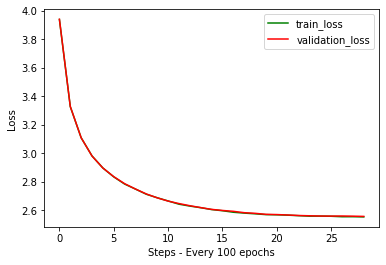

In [22]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Inference

In [23]:
#Load the model
model = Gemma3Model(GEMMA3_CONFIG_270M)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states

<All keys matched successfully>

In [25]:
sentence = "Grandmother was telling the kids story about a unicorn"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Grandmother was telling the kids story about a unicorn and sharing.Lily and Tom were best friends. They liked to play in their yard again and have a race. They shared their hats together and became bridge and exploring the world't the respect she was safe.

One day, Lily and Tom hugged and she went over the bridge. Then they were nice and good. Lily felt like she accidentally dropped her teddy lights and she used herEnable new battery to make her grumbled. The whole day fell down and looked back.

Lily and her mommy did. They looked at her room and hurt her knee. They asked him to stop playing with them. They said they couldn't help but learn.

CHR bank, Lily took Lola on her head. She was very curious and careful with her new parents. They went off to play catch with her again. Lily learned that being cheerful than little bubbles piece on clouds.Once upon a time, there was a little girl who loved their family. She would always


In [27]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 KB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.7 MB/s eta 0:00:00


In [29]:
import os
import json
import torch
from transformers import GPT2Tokenizer
from huggingface_hub import HfApi, create_repo

In [30]:
def save_model_for_huggingface():
    # Create the save directory
    save_dir = "gemma-270m-tinystories"
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Copy your existing model state dict to the proper name
    model_save_path = os.path.join(save_dir, "pytorch_model.bin")
    
    # Load your best model state dict and save it with the correct name
    if os.path.exists("best_model_params.pt"):
        state_dict = torch.load("best_model_params.pt", map_location="cpu")
        torch.save(state_dict, model_save_path)
        print(f"Copied best_model_params.pt to {model_save_path}")
    else:
        print("Error: best_model_params.pt not found!")
        return None
    
    # 2. Create and save the config.json
    config = {
        "architectures": ["Gemma3Model"],
        "model_type": "gemma3",
        "vocab_size": GEMMA3_CONFIG_270M["vocab_size"],
        "max_position_embeddings": GEMMA3_CONFIG_270M["context_length"],
        "hidden_size": GEMMA3_CONFIG_270M["emb_dim"],
        "num_attention_heads": GEMMA3_CONFIG_270M["n_heads"],
        "num_hidden_layers": GEMMA3_CONFIG_270M["n_layers"],
        "intermediate_size": GEMMA3_CONFIG_270M["hidden_dim"],
        "torch_dtype": "bfloat16",
        "transformers_version": "4.36.0",
        # Custom Gemma3 specific configs
        "head_dim": GEMMA3_CONFIG_270M["head_dim"],
        "n_kv_groups": GEMMA3_CONFIG_270M["n_kv_groups"],
        "qk_norm": GEMMA3_CONFIG_270M["qk_norm"],
        "rope_local_base": GEMMA3_CONFIG_270M["rope_local_base"],
        "rope_base": GEMMA3_CONFIG_270M["rope_base"],
        "sliding_window": GEMMA3_CONFIG_270M["sliding_window"],
        "layer_types": GEMMA3_CONFIG_270M["layer_types"],
        "query_pre_attn_scalar": GEMMA3_CONFIG_270M["query_pre_attn_scalar"]
    }
    
    config_path = os.path.join(save_dir, "config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    
    # 3. Use GPT2Tokenizer since you used tiktoken's gpt2 encoding
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.save_pretrained(save_dir)
    
    # 4. Create a README.md
    readme_content = """---
language: en
tags:
- text-generation
- gemma
- tinystories
license: apache-2.0
datasets:
- roneneldan/TinyStories
---

# Gemma-3 270M Fine-tuned on TinyStories

This is a custom implementation of Gemma-3 270M parameter model fine-tuned on the TinyStories dataset.

## Model Details
- **Architecture**: Custom Gemma-3 with sliding window attention
- **Parameters**: ~270M
- **Training Dataset**: TinyStories
- **Context Length**: 32,768 tokens
- **Sliding Window**: 512 tokens

## Usage

```python
# Note: This model requires the custom Gemma3Model class from the training notebook
# You'll need to copy the model definition to use this model
```

## Training Details
- Trained for 150,000 steps
- Final training loss: ~2.55
- Final validation loss: ~2.56
"""
    
    readme_path = os.path.join(save_dir, "README.md")
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    
    return save_dir

# Save the model
save_dir = save_model_for_huggingface()

Copied best_model_params.pt to gemma-270m-tinystories/pytorch_model.bin


In [ ]:
username = "chinmaydk99"
repo_name = f"{username}/gemma-270m-tinystories"

from huggingface_hub import HfApi, create_repo

# Initialize API with your token
api = HfApi(token=HF_TOKEN)

# Create the repository
try:
    create_repo(
        repo_id=repo_name, 
        repo_type="model", 
        exist_ok=True,
        token=HF_TOKEN
    )
    print(f"Repository {repo_name} created/verified")
except Exception as e:
    print(f"Repository creation: {e}")

# Upload all the files
try:
    api.upload_folder(
        folder_path=save_dir,
        repo_id=repo_name,
        repo_type="model",
        commit_message="Upload custom Gemma-3 270M fine-tuned on TinyStories",
        token=HF_TOKEN
    )
    print(f"🎉 Model uploaded successfully!")
    print(f"View your model at: https://huggingface.co/{repo_name}")
except Exception as e:
    print(f"Upload failed: {e}")
    print("\nIf upload fails, you can download the files and upload manually:")
    print(f"1. Download the '{save_dir}' folder from Lambda Labs")
    print(f"2. Go to https://huggingface.co/new")
    print(f"3. Create repository '{repo_name.split('/')[-1]}'")
    print(f"4. Upload the files manually through the web interface")